### AB Testing

In [335]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px


In [308]:
import warnings
warnings.filterwarnings('ignore')

In [309]:
import numpy as np
import pandas as pd
import plots
import scipy.stats as scs

from helper import Helper


In [310]:
CSV_PATH = "../Data/data.csv"

In [311]:
helper = Helper()

### Reading the data

In [312]:
df = helper.read_csv(CSV_PATH)
df.head()

file read as csv


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [313]:
print(f"number of rows: {df.shape[0]}")
print(f"number of cols: {df.shape[1]}")

df.info()

number of rows: 8077
number of cols: 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


### Missing Value Analysis

In [314]:
print(f"percent of missing values in our data is {helper.percent_missing(df)}%")

percent of missing values in our data is 0.0%


### Control Group Vs Experiment Group

In [315]:

contorl_num = df.groupby('experiment').agg({'auction_id': 'count'})['auction_id']['control']
exposed_num  = df.groupby('experiment').agg({'auction_id': 'count'})['auction_id']['exposed']

print(f"the number of entries in control group is {contorl_num}")
print(f"the number of entries in experiment group is {exposed_num}")






the number of entries in control group is 4071
the number of entries in experiment group is 4006


### EDA for our data

#### The number of entries in Control group vs the experiment group

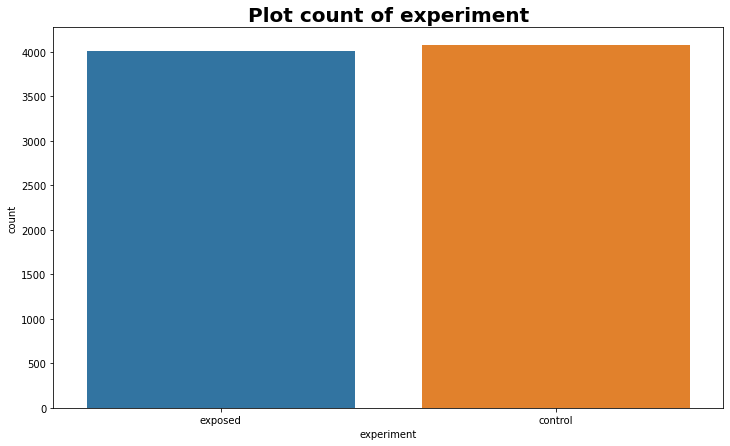

In [316]:
plots.plot_count(df, 'experiment')

You can see that the number of the exposed group and control group are some what similar

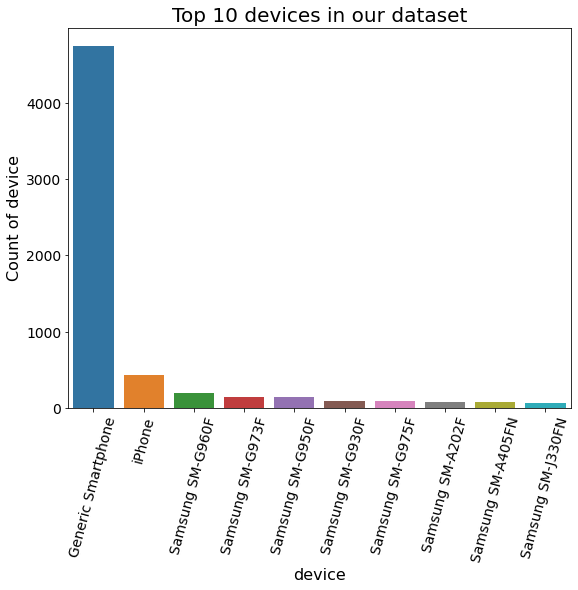

In [317]:
device_df = df.groupby('device_make').agg({"device_make": 'count'})
device_df = device_df.rename(columns={'device_make': "Count of device"})
device_df['device'] = device_df.index
device_df = device_df.sort_values(by="Count of device", ascending=False)

plots.plot_bar(device_df.head(10), x_col='device', y_col='Count of device',
               title="Top 10 devices in our dataset", xlabel="device", ylabel="Count of device")



#### Most of the device in our sample is from Generic smarthphone
#### There are also many devices from samsung brand

### The number of yes and no answers in each group

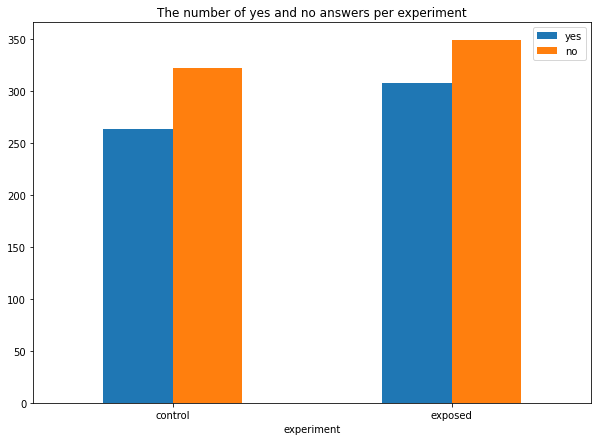

In [318]:

yes_no_agg = df.groupby('experiment').agg({'yes': 'sum', 'no': 'sum'})
ax = yes_no_agg.plot.bar( y=['yes', 'no'],  title="The number of yes and no answers per experiment",
                          rot=0, figsize=(10,7))

#### The range differnce b/n the total number of yes anwers minus the total number of no answers has increased in exposed group

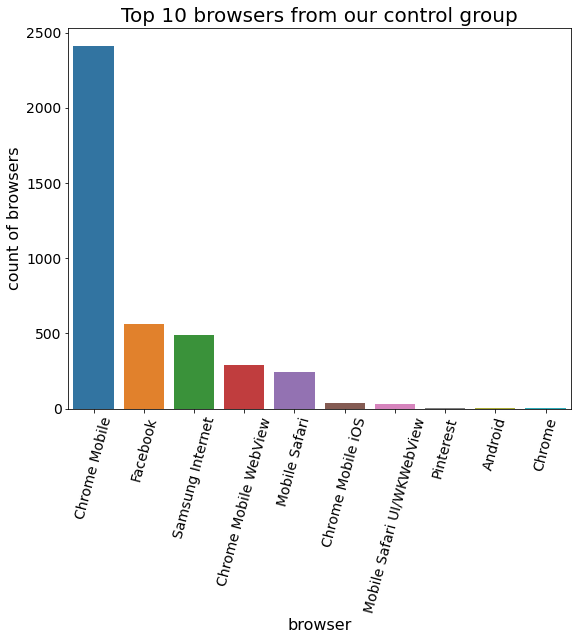

In [319]:
browser_control_df = df[df['experiment'] == "control"]
browser_control_df = browser_control_df[['browser', 'experiment']].sort_values(by="browser", ascending=False)
browser_control_df = browser_control_df.groupby('browser').agg({'browser': 'count'})
browser_control_df = browser_control_df.rename(columns={'browser': 'count of browsers'})
browser_control_df['browser'] = browser_control_df.index
browser_control_df = browser_control_df.sort_values(by="count of browsers", ascending=False)
plots.plot_bar(browser_control_df.head(10), x_col='browser', y_col='count of browsers',
               title="Top 10 browsers from our control group", xlabel="browser", ylabel="count of browsers")

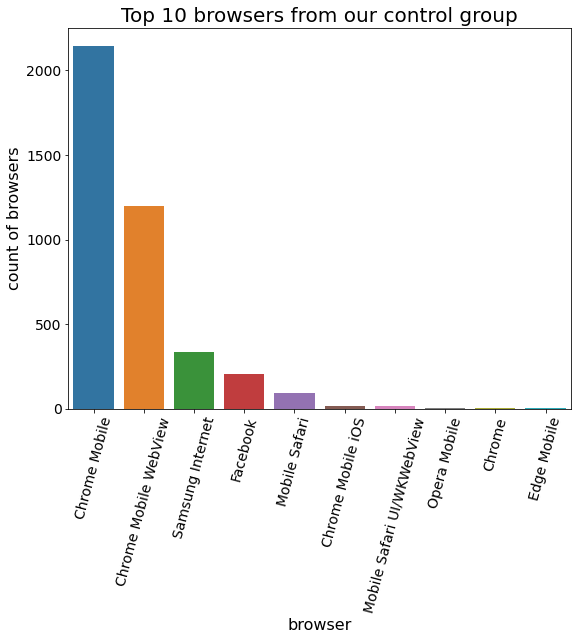

In [320]:
browser_exposed_df = df[df['experiment'] == "exposed"]
browser_exposed_df = browser_exposed_df[['browser', 'experiment']].sort_values(by="browser", ascending=False)
browser_exposed_df = browser_exposed_df.groupby('browser').agg({'browser': 'count'})
browser_exposed_df = browser_exposed_df.rename(columns={'browser': 'count of browsers'})
browser_exposed_df['browser'] = browser_exposed_df.index
browser_exposed_df = browser_exposed_df.sort_values(by="count of browsers", ascending=False)
plots.plot_bar(browser_exposed_df.head(10), x_col='browser', y_col='count of browsers',
               title="Top 10 browsers from our control group", xlabel="browser", ylabel="count of browsers")

### The hour distribution of the experiment

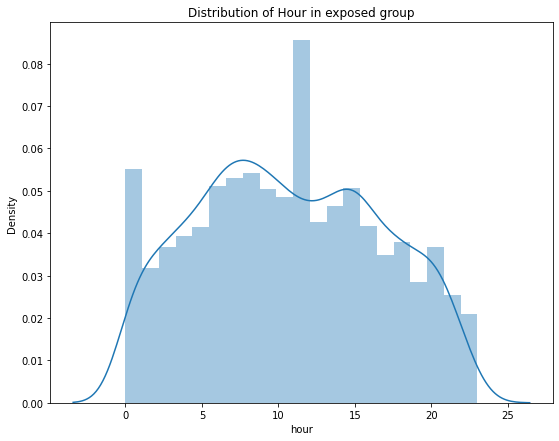

In [321]:
exposed_group = df[df['experiment'] == 'exposed']
plots.plot_dist(exposed_group['hour'], 'Hour in exposed group')


the hour of the experiment for exposed group seems evenly distributed

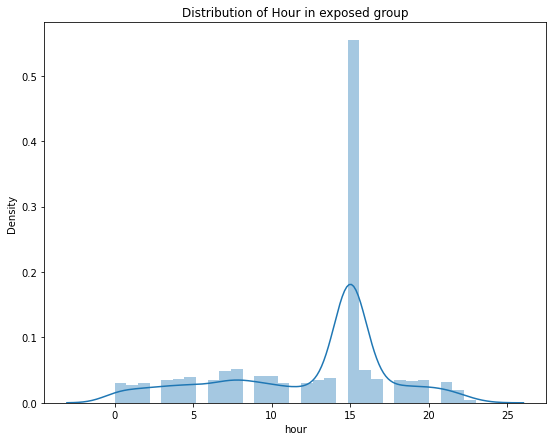

In [322]:
control_group = df[df['experiment'] == 'control']
plots.plot_dist(control_group['hour'], 'Hour in exposed group')


Most of the conrol group data was taken around 15 hr

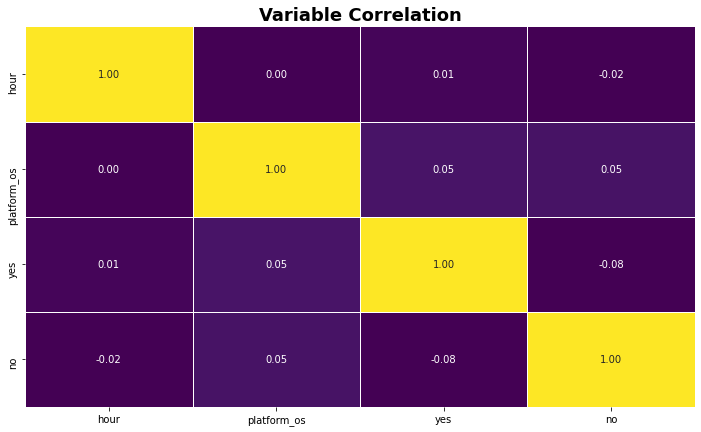

In [323]:
data = df.copy()
data_correlation = data.drop('auction_id', axis=1).corr()
plots.plot_heatmap(data_correlation, 'Variable Correlation')
# data_correlation


### Data Cleaning

In [324]:
cleaned_df = df[['auction_id', 'experiment', 'yes', 'no']]
not_ans_df = cleaned_df.query("yes == 0 & no == 0")
not_ans_df

,auction_id,experiment,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,0,0
3,00187412-2932-4542-a8ef-3633901c98d9,control,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,0,0
5,0027ce48-d3c6-4935-bb12-dfb5d5627857,control,0,0
...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,0,0


In [325]:
print(f"the number of users that did not respond is {not_ans_df.shape[0]} ")
print(f"the percentage of users that did not respond is {(not_ans_df.shape[0] / df.shape[0]) * 100:0.2f}% ")

the number of users that did not respond is 6834 
the percentage of users that did not respond is 84.61% 


Around 85 percent of our users did not respond to the questioner. that is a real disadvantage

In [326]:
cleaned_df = cleaned_df.query("not (yes == 0 & no == 0)")
cleaned_df.groupby("experiment").agg({"yes": "sum", "no":"sum"})

cleaned_df_agg = cleaned_df.groupby("experiment").agg({"yes": "sum", "no":"sum"})
cleaned_df_agg['aware'] = [0,0]
cleaned_df_agg['aware']['control'] = cleaned_df_agg['yes']['control']
cleaned_df_agg['aware']['exposed'] = cleaned_df_agg['yes']['exposed']

cleaned_df_agg['total'] = [0, 0]
cleaned_df_agg['total']['control'] = cleaned_df_agg['yes']['control'] +  cleaned_df_agg['no']['control']
cleaned_df_agg['total']['exposed'] = cleaned_df_agg['yes']['exposed'] + cleaned_df_agg['no']['exposed']

print(f"number of pepole that are aware of the brand lux in control group are: {cleaned_df_agg['aware']['control']}")
print(f"number of pepole that are aware of the brand lux in exposed group are: {cleaned_df_agg['aware']['exposed']}")

test_df = cleaned_df_agg.copy()
test_df

number of pepole that are aware of the brand lux in control group are: 264
number of pepole that are aware of the brand lux in exposed group are: 308


,yes,no,aware,total
experiment,,,,
control,264,322,264,586
exposed,308,349,308,657


### calculating the conversion rate
our metrics is a conversion rate for awareness / total


In [327]:

control_conversion_rate = test_df['aware']['control'] / test_df['total']['control']
exposed_conversion_rate = test_df['aware']['exposed'] / test_df['total']['exposed']

print(f" The conversion rate of control group is {control_conversion_rate:0.2f}")
print(f" The conversion rate of exposed group is {exposed_conversion_rate:0.2f}")

 The conversion rate of control group is 0.45
 The conversion rate of exposed group is 0.47


### calculating the variance of the contorl group and exposed group

diff = exposed_conversion_rate - control_conversion_rate

variance_contorl = control_conversion_rate * (1 - control_conversion_rate)
variance_exposed = exposed_conversion_rate * (1 - exposed_conversion_rate)




### calculating the standard error for sampling distribution of the contorl group and exposed group

In [328]:
contorl_total = cleaned_df_agg['total']['control']
exposed_total = cleaned_df_agg['total']['exposed']

standar_err_control = np.sqrt(variance_contorl)/np.sqrt(contorl_total)
standar_err_exposed = np.sqrt(variance_exposed)/np.sqrt(exposed_total)

### Calculating the shift in awareness

In [329]:
shift  = (exposed_conversion_rate - control_conversion_rate) / control_conversion_rate


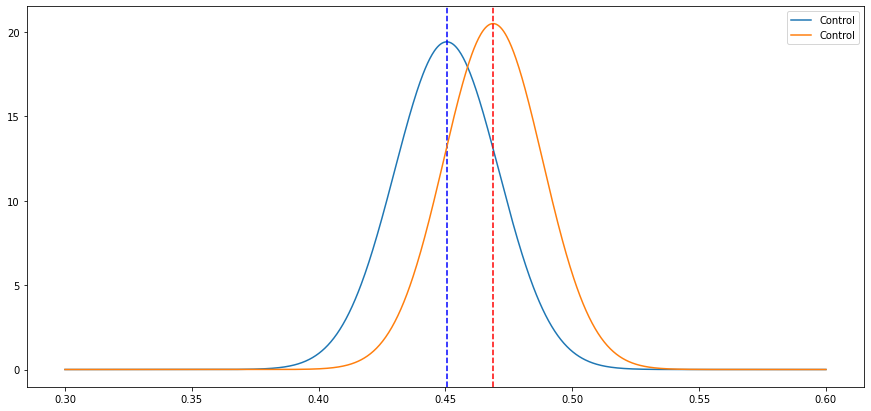

In [343]:
fig, ax = plt.subplots(figsize=(15,7))

x = np.linspace(0.3, 0.6, 1000)

ctr_rate_prob = scs.norm(control_conversion_rate, standar_err_control).pdf(x)
ax.plot(x, ctr_rate_prob, label='Control')
ax.axvline(x=control_conversion_rate, c='blue', linestyle='--')



exposed_rate_prob = scs.norm(exposed_conversion_rate, standar_err_exposed).pdf(x)
ax.plot(x, exposed_rate_prob, label='Control')
ax.axvline(x=exposed_conversion_rate, c='red', linestyle='--')
plt.legend()

***The graph shows that the awarness has been shifted to the left for the exposed group***

In [331]:
print(f"The awareness of the exposed group has been shifted/increased by {shift * 100:0.2f}%" )

The awareness of the exposed group has been shifted/increased by 4.06%


### Conducting the null hypothesis test to check if the increase in awareness is siginificant

In [332]:

def is_significant(A_rate, B_rate, A_total, B_total, alpha=0.05, tail="one"):
    diff = B_rate - A_rate
    
    A_variance =  A_rate * (1 - A_rate)
    B_variance  = B_rate * (1 - B_rate)
    
    z_score = diff / np.sqrt((A_variance/A_total) + (B_variance/B_total))

    p_value  = scs.norm().sf(z_score)
    
    if (tail == "one"):
        compare = alpha
    else:
        comapre = alpha / 2
        
    return abs(p_value) < alpha, p_value, z_score
        


In [333]:
alpha = 1 - 0.95

is_signi, p_value, z_score = is_significant(control_conversion_rate, exposed_conversion_rate,
                                            contorl_total, exposed_total, alpha=alpha)


z_score = diff / np.sqrt((variance_contorl/contorl_total) + (variance_exposed/exposed_total))
print (f"the calculated z score is {z_score:0.2f}" )

p_value  = scs.norm().sf(z_score)
print (f"the calculated p value is {p_value:0.2f}" )

is_signi, p_value, z_score = is_significant(control_conversion_rate, exposed_conversion_rate,
                                            contorl_total, exposed_total)

print(f"Is the value significant: {is_signi}")


the calculated z score is 0.65
the calculated p value is 0.26
Is the value significant: False


***Since our P_value > 0.05, Our increase in awarness is not significant and we reject our alternative hypothesis. There is a high probablity that this could be due to chance or natural variation***

The p vaue is telling us that the probablity of seeing this increase in awareness in our exposed group  is 26%, but to say the increase in awareness is significant we needed the
probablity to be  below as 5% having 95% as statstical significance

The confidence interval can be calulated by 100% - 26% = 74%. So 74% of the time the exposed group is going to have the same awareness as the control group